 # <u>Financial Analysis</u><a class="anchor" id = "outline"></a>

 ##### Presented by Supriya Prasad
 ###### Created on 9/2/2024
 <br>

### <u>Table of Contents</u>


 [1. Problem Statement](#problem)<br>
 [2. Import and Data Cleansing](#getdata)<br>
 [3. Solution with Code](#solution)<br><ul>
 [3.1. Pricing](#q1)<br>
     [3.2. Customer Conversion Rate](#q2)<br>
     [3.3. Margin](#q3)<br>
     [3.4. Recommendation](#q4)<br>
     [3.5. Other Factors](#q5)<br></ul>
     
 [4. Conclusion and Notes](#notes)<br>
 [5. Additional EDA for Reference](#eda)<br>



 Click on any of the links above to take you directly to that section

### Problem Statement<a class="anchor" id = "problem"></a>

CarPro provides financing to our customers to help them purchase their vehicle. CarPro needs to decide what APR's (interest rate) they'd like to offer customers
on those loans. The rate we offer affects the profitability of the loans we originate, as
well as the likelihood that the customer purchases a vehicle from CarPro.<br>
To help us optimize the rate offering, we run randomized experimentation so that we
can measure how things change as we adjust the rates we offer.
Attached is a sample psuedo-realistic data set. Here's a quick
data dictionary:
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Column Descriptions</title>
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
        }
        th, td {
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
</head>
<body>
    <h4>Column Descriptions</h4>
    <table>
        <thead>
            <tr>
                <th>Column Name</th>
                <th>Description</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>app_id</td>
                <td>ID number of the application</td>
            </tr>
            <tr>
                <td>fico</td>
                <td>The FICO score of the applicant (700 or 600 in this exercise)</td>
            </tr>
            <tr>
                <td>apr_test_group</td>
                <td>Whether or not the applicant is in the test group (randomized)</td>
            </tr>
            <tr>
                <td>apr</td>
                <td>The APR that CarPro offers the customer</td>
            </tr>
            <tr>
                <td>converted to sale</td>
                <td>Whether or not the applicant ended up buying a car from CarPro</td>
            </tr>
            <tr>
                <td>vehicle margin</td>
                <td>The profit that CarPro makes on selling the vehicle</td>
            </tr>
            <tr>
                <td>finance margin</td>
                <td>The profit that CarPro makes on the loan to the customer (after selling the loan to a counter-party at a fair price)</td>
            </tr>
        </tbody>
    </table>


<br>
I'm working on certain aspects of the credit risk for deciding the lending of loans to customers who purchase their products. Some of the factors considered are as follows:<br>
1. CarPro pricing<br>
2. Customer conversion rate<br>
3. CarPro margin<br>
4. Effect of APR on total margin<br>
5. Other factors to consider<br><br>

[Go to top of the page](#outline)<br>
<br><br>
### Import and Data Cleansing<a class="anchor" id = "getdata"></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
file_path = 'Finance_Analysis.csv'
df = pd.read_csv(file_path)

In [ ]:
print(df.tail())
print(df.info())
print(df.describe())

       app_id  fico apr_test_group    apr  converted to sale  vehicle margin  \
19995   19996   600           test  4.40%               True          1000.0   
19996   19997   600           test  4.40%              False             NaN   
19997   19998   600           test  4.40%              False             NaN   
19998   19999   600        control  5.40%              False             NaN   
19999   20000   600        control  5.40%              False             NaN   

       finance margin  
19995           400.0  
19996             NaN  
19997             NaN  
19998             NaN  
19999             NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   app_id             20000 non-null  int64  
 1   fico               20000 non-null  int64  
 2   apr_test_group     20000 non-null  object 
 3   apr                200

In [ ]:
# Converting APR test group to a categorical variable
df['apr_test_group'] = df['apr_test_group'].astype('category')

# Converting APR to a numeric variable
df['apr'] = df['apr'].astype(str)
df['apr'] = df['apr'].str.replace('%', '').astype(float)

# Analysis of total margin (vehicle + finance)
df['total margin'] = df['vehicle margin'] + df['finance margin']

#Splitting data into control and test dataframes for ease of calculations
df_control = df[df['apr_test_group'] == 'control']
df_test_group = df[df['apr_test_group'] == 'test']

print(df.tail())
print(df.info())
print(df.describe())

       app_id  fico apr_test_group  apr  converted to sale  vehicle margin  \
19995   19996   600           test  4.4               True          1000.0   
19996   19997   600           test  4.4              False             NaN   
19997   19998   600           test  4.4              False             NaN   
19998   19999   600        control  5.4              False             NaN   
19999   20000   600        control  5.4              False             NaN   

       finance margin  total margin  
19995           400.0        1400.0  
19996             NaN           NaN  
19997             NaN           NaN  
19998             NaN           NaN  
19999             NaN           NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   app_id             20000 non-null  int64   
 1   fico               20000 non-null  int64   

In [ ]:
# Check for missing values
print("\nMissing Values")
print(df.isnull().sum())


Missing Values
app_id                   0
fico                     0
apr_test_group           0
apr                      0
converted to sale        0
vehicle margin       14979
finance margin       14979
total margin         14979
dtype: int64



[Go to top of the page](#outline)<br>

## Solutions<a class="anchor" id = "solution"></a>

### Pricing<a class="anchor" id = "q1"></a>
#### What’s the current APR pricing strategy for the different FICO buckets?<br>


Current APR Pricing Strategy by FICO Bucket
   fico  apr
0   600  5.4
1   700  4.0


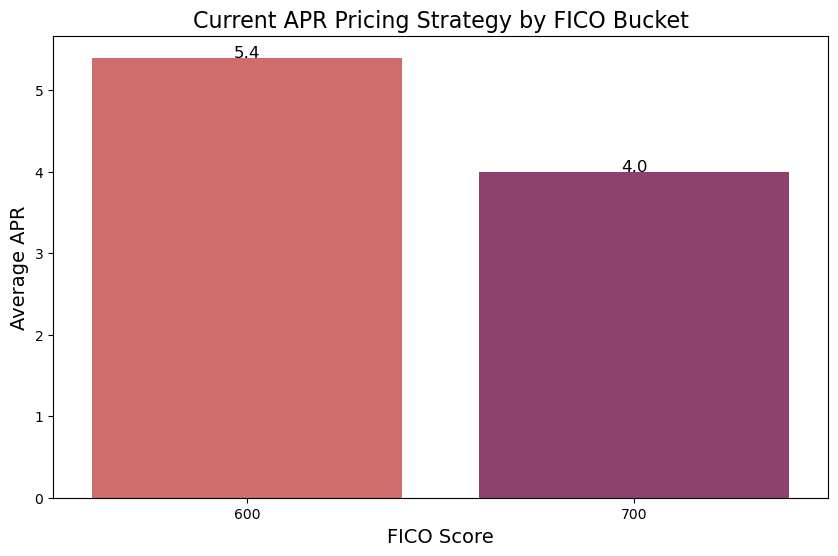

In [ ]:
apr_pricing_strategy_control = df_control.groupby('fico')['apr'].mean().reset_index()

print("\nCurrent APR Pricing Strategy by FICO Bucket")
print(apr_pricing_strategy_control)


# Bar plot for APR Pricing Strategy by FICO Bucket (Current)
plt.figure(figsize=(10, 6))
sns.barplot(x='fico', y='apr', data=apr_pricing_strategy_control, palette='flare')

plt.title('Current APR Pricing Strategy by FICO Bucket', fontsize=16)
plt.xlabel('FICO Score', fontsize=14)
plt.ylabel('Average APR', fontsize=14)
for index, row in apr_pricing_strategy_control.iterrows():
    plt.text(row.name, row.apr + 0.01, round(row.apr, 2), color='black', ha="center", fontsize=12)

plt.show()


APR Pricing Strategy by FICO Bucket and APR Test Group
   fico apr_test_group  apr
0   600        control  5.4
1   600           test  4.4
2   700        control  4.0
3   700           test  3.0


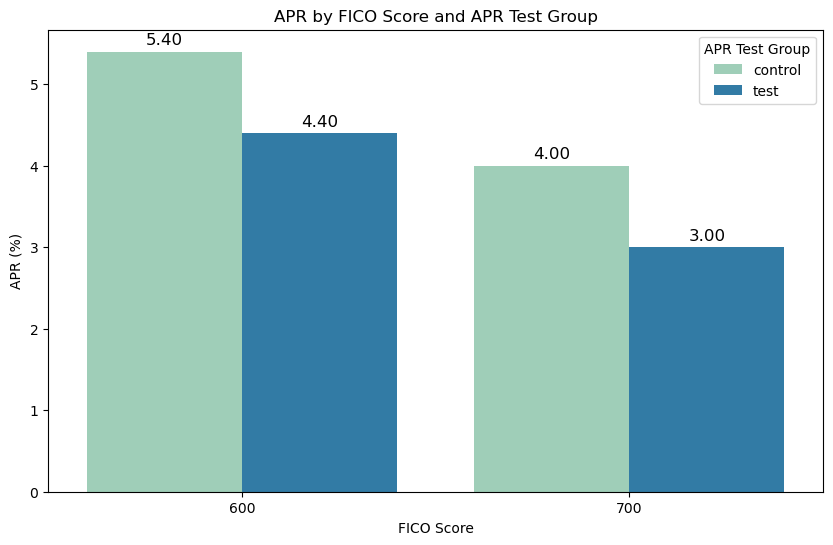

In [ ]:
# Also, grouping the dataframe by fico and apr group gives the apr pricing stategy overall

mean_apr_pricing_strategy = df.groupby(['fico', 'apr_test_group'])['apr'].mean().reset_index()

print("\nAPR Pricing Strategy by FICO Bucket and APR Test Group")
print(mean_apr_pricing_strategy)

# Visualizing the Mean APR Pricing Strategy with Barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='fico', y='apr', hue='apr_test_group', data=mean_apr_pricing_strategy, palette='YlGnBu')
plt.title('APR by FICO Score and APR Test Group')
plt.xlabel('FICO Score')
plt.ylabel('APR (%)')
plt.legend(title='APR Test Group')

for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='baseline', fontsize=12, color='black',
                     xytext=(0, 5), textcoords='offset points')

plt.show()


#### How is the randomized test structure?

In [ ]:
# Summary statistics for APR based on the APR Test Group
test_group_summary = df.groupby('apr_test_group')['apr'].describe().reset_index()

print("\nAPR Summary Statistics by APR Test Group")
print(test_group_summary)

# Mean APR and count for each test group
mean_apr = df.groupby('apr_test_group')['apr'].mean().reset_index(name='mean_apr')
count_apr = df.groupby('apr_test_group')['apr'].count().reset_index(name='count_apr')

print("\nAverage APR by APR Test Group is")
print(mean_apr)

print("\nApplication count by APR Test Group")
print(count_apr)

#APR difference
control_mean_apr = mean_apr.loc[mean_apr['apr_test_group'] == 'control', 'mean_apr'].values[0]
test_mean_apr = mean_apr.loc[mean_apr['apr_test_group'] == 'test', 'mean_apr'].values[0]
apr_diff = control_mean_apr - test_mean_apr

print("\nSummary of APR Difference:\n")
print(f"The test group APR is {apr_diff:.2f}% lower than the control group.\nCounts of each group are almost the same with control group being 50.105% and test group being 49.895%\nDistribution of margins haven't chaged much in both the subgroups as the standard deviation also remains almost the same.\n")


APR Summary Statistics by APR Test Group
  apr_test_group    count      mean       std  min  25%  50%  75%  max
0        control  10021.0  4.711805  0.699935  4.0  4.0  5.4  5.4  5.4
1           test   9979.0  3.688285  0.699937  3.0  3.0  3.0  4.4  4.4

Average APR by APR Test Group is
  apr_test_group  mean_apr
0        control  4.711805
1           test  3.688285

Application count by APR Test Group
  apr_test_group  count_apr
0        control      10021
1           test       9979

Summary of APR Difference:

The test group APR is 1.02% lower than the control group.
Counts of each group are almost the same with control group being 50.105% and test group being 49.895%
Distribution of margins haven't chaged much in both the subgroups as the standard deviation also remains almost the same.



#### How do APR's vary by test group?

In [ ]:
#APR statistics for each test group
apr_group_stats = df.groupby('apr_test_group')['apr'].describe().reset_index()

print("\nAPR Statistics by Test Group")
print(apr_group_stats)


APR Statistics by Test Group
  apr_test_group    count      mean       std  min  25%  50%  75%  max
0        control  10021.0  4.711805  0.699935  4.0  4.0  5.4  5.4  5.4
1           test   9979.0  3.688285  0.699937  3.0  3.0  3.0  4.4  4.4



APR Statistics by FICO Bucket and Test Group
   fico apr_test_group   count  mean           std  min  25%  50%  75%  max
0   600        control  5095.0   5.4  4.352501e-13  5.4  5.4  5.4  5.4  5.4
1   600           test  4906.0   4.4  1.554471e-13  4.4  4.4  4.4  4.4  4.4
2   700        control  4926.0   4.0  0.000000e+00  4.0  4.0  4.0  4.0  4.0
3   700           test  5073.0   3.0  0.000000e+00  3.0  3.0  3.0  3.0  3.0

APR Values by FICO Score and APR Test Group
   fico apr_test_group  apr
0   600        control  5.4
1   600           test  4.4
2   700        control  4.0
3   700           test  3.0


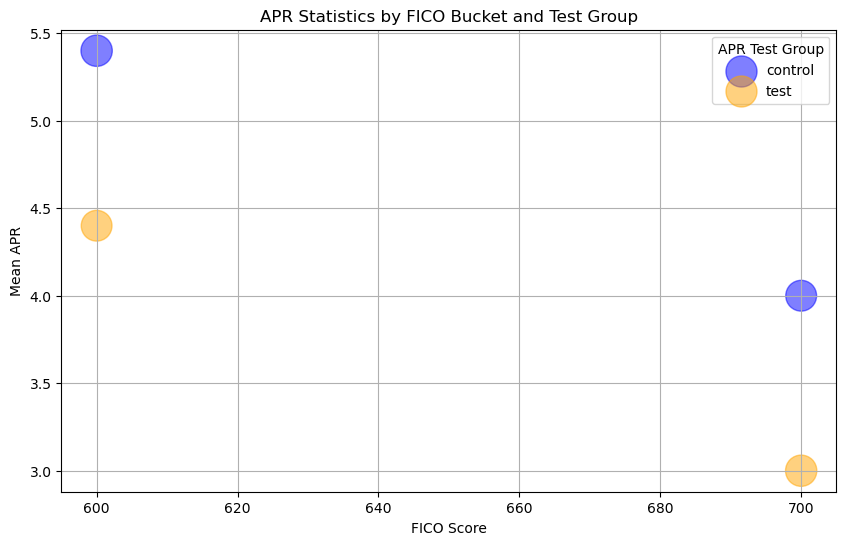

In [ ]:
# Group by FICO and APR Test Group for descriptive statistics for APR
apr_fico_test_group_stats = df.groupby(['fico', 'apr_test_group'])['apr'].describe().reset_index()

print("\nAPR Statistics by FICO Bucket and Test Group")
print(apr_fico_test_group_stats)

apr_summary = df.groupby(['fico', 'apr_test_group'])['apr'].mean().reset_index()

print("\nAPR Values by FICO Score and APR Test Group")
print(apr_summary)

colors = {'control': 'blue', 'test': 'orange'}

# Create bubble chart
plt.figure(figsize=(10, 6))

# Plot each group with different colors and sizes
for group in apr_fico_test_group_stats['apr_test_group'].unique():
    subset = apr_fico_test_group_stats[apr_fico_test_group_stats['apr_test_group'] == group]
    plt.scatter(
        subset['fico'],
        subset['mean'],
        s=subset['count'] / 10,  # Adjust bubble size
        c=colors[group],
        alpha=0.5,
        label=group
    )

# Adding titles and labels
plt.title('APR Statistics by FICO Bucket and Test Group')
plt.xlabel('FICO Score')
plt.ylabel('Mean APR')
plt.grid(True)
plt.legend(title='APR Test Group')
plt.show()


[Go to top of the page](#outline)<br>

### Customer Conversion Rate<a class="anchor" id = "q2"></a>
#### In general, how many applications is CarPro able to convert to a sale?<br>

In [ ]:
# Considering only control group as they are the current applications
total_applications = df_control.shape[0]
total_conversions = df_control['converted to sale'].sum()
overall_conversion_rate = total_conversions / total_applications

print("CarPro is able to convert ", total_conversions," appplications out of the ", total_applications," into a sale.")
print(f"\nThe Overall Conversion Rate is: {overall_conversion_rate:.2%}")


Carvana is able to convert  2344  appplications out of the  10021  into a sale.

The Overall Conversion Rate is: 23.39%


#### How does that vary by FICO?


Conversion Rate by FICO Score:
   fico  total_conversions  total_applications  conversion_rate
0   600               1044                5095        20.490677
1   700               1300                4926        26.390581


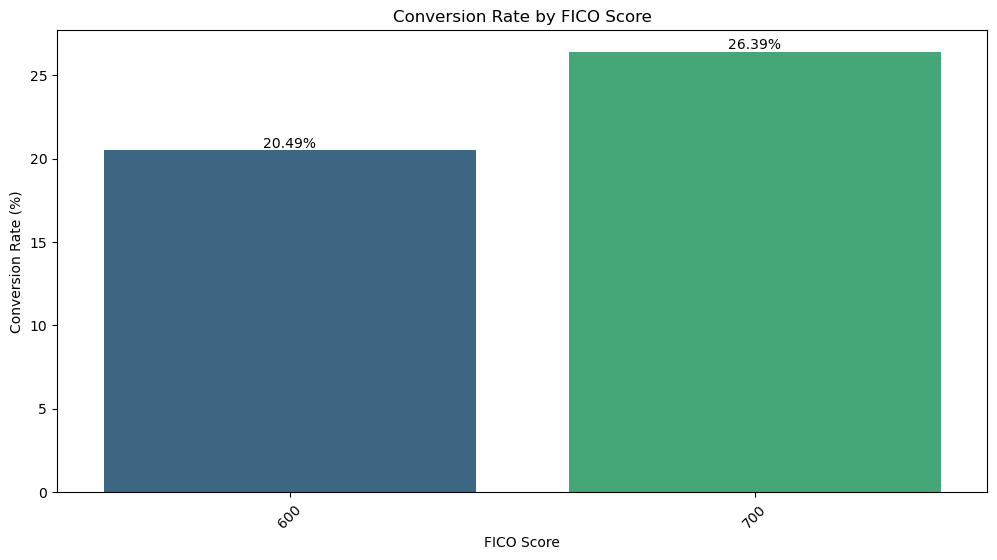

In [ ]:

# Total applications and conversions by FICO score
fico_conversion_summary = df_control.groupby('fico')['converted to sale'].agg(['sum', 'count']).reset_index()
fico_conversion_summary.columns = ['fico', 'total_conversions', 'total_applications']

# Conversion rate by FICO score
fico_conversion_summary['conversion_rate'] = fico_conversion_summary['total_conversions'] / fico_conversion_summary['total_applications'] * 100

print("\nConversion Rate by FICO Score:")
print(fico_conversion_summary)

# Plotting the conversion rate by FICO score
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='fico', y='conversion_rate', data=fico_conversion_summary, palette='viridis')
plt.title('Conversion Rate by FICO Score')
plt.xlabel('FICO Score')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points', fontsize=10, color='black')

plt.show()



#### Using the APR test group data, how does the APR affect conversion?


Conversion Rate by APR Value (Test Group):
   apr  total_conversions  total_applications  conversion_rate
0  3.0               1505                5073        29.666864
1  4.4               1172                4906        23.889115


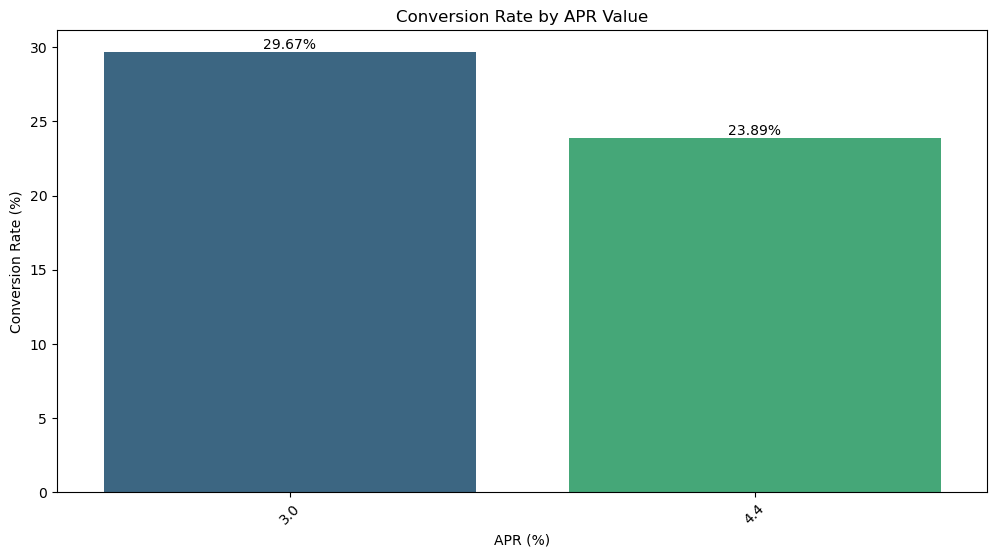


Conversion Rate by FICO Score:
   fico  total_conversions  total_applications  conversion_rate
0   600               1172                4906        23.889115
1   700               1505                5073        29.666864

Both APR vs Conversion rate and FICO vs Conversion rate show the same rate because the data has one on one relationship between APR and FICO when the APR test group is considered


In [ ]:
# Total applications and conversions by APR value for test group
apr_conversion_summary = df_test_group.groupby('apr')['converted to sale'].agg(['sum', 'count']).reset_index()
apr_conversion_summary.columns = ['apr', 'total_conversions', 'total_applications']

# Conversion rate by APR value
apr_conversion_summary['conversion_rate'] = apr_conversion_summary['total_conversions'] / apr_conversion_summary['total_applications'] * 100

print("\nConversion Rate by APR Value (Test Group):")
print(apr_conversion_summary)

# Plotting the conversion rate by APR value
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='apr', y='conversion_rate', data=apr_conversion_summary, palette='viridis')
plt.title('Conversion Rate by APR Value')
plt.xlabel('APR (%)')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points', fontsize=10, color='black')

plt.show()

# Now calculating by FICO score aswell

# Total applications and conversions by FICO score in the test group
fico_conversion_summary_test = df_test_group.groupby('fico')['converted to sale'].agg(['sum', 'count']).reset_index()
fico_conversion_summary_test.columns = ['fico', 'total_conversions', 'total_applications']

# Conversion rate by FICO score
fico_conversion_summary_test['conversion_rate'] = fico_conversion_summary_test['total_conversions'] / fico_conversion_summary_test['total_applications'] * 100

print("\nConversion Rate by FICO Score:")
print(fico_conversion_summary_test)

print('\nBoth APR vs Conversion rate and FICO vs Conversion rate show the same rate because the data has one on one relationship between APR and FICO when the APR test group is considered')



[Go to top of the page](#outline)<br>

### Margin<a class="anchor" id = "q3"></a>
#### What does CarPro make in margin overall (vehicle +financing), per sale and per application?<br>

In [ ]:
# Calculating margins for control group
margin_per_sale = df_control['total margin'].sum() / df_control['converted to sale'].sum()
margin_per_application = df_control['total margin'].sum() / df_control.shape[0]

print(f"Overall Margin Per Sale: ${margin_per_sale:.2f}")
print(f"Overall Margin Per Application: ${margin_per_application:.2f}")

Overall Margin Per Sale: $1622.27
Overall Margin Per Application: $379.46


#### How does APR affect the financemargin per sale?

Finance Margin by APR:
      count   mean  std    min    25%    50%    75%    max
apr                                                       
4.0  1300.0  600.0  0.0  600.0  600.0  600.0  600.0  600.0
5.4  1044.0  650.0  0.0  650.0  650.0  650.0  650.0  650.0


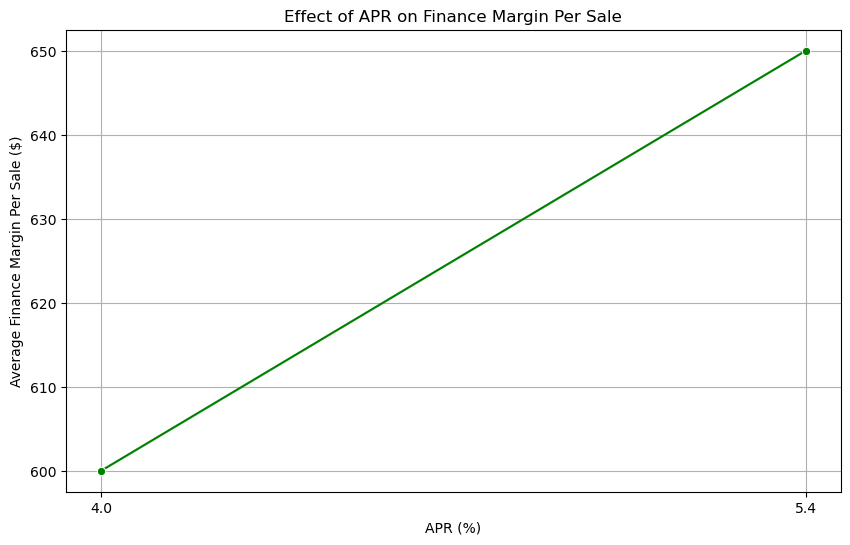

In [ ]:
# Descriptive statistics for finance margin by APR value

df_control_sale = df_control[df_control['converted to sale'] == True]
finance_margin_by_apr = df_control.groupby('apr')['finance margin'].describe()
print('Finance Margin by APR:')
print(finance_margin_by_apr)


plt.figure(figsize=(10, 6))
sns.lineplot(x='apr', y='finance margin', data=df_control, marker='o', color='g')

# Customizing the plot
plt.title('Effect of APR on Finance Margin Per Sale')
plt.xlabel('APR (%)')
plt.ylabel('Average Finance Margin Per Sale ($)')
plt.grid(True)
plt.xticks(df_control['apr'].unique())

# Show the plot
plt.show()



#### How does FICO affect the finance margin per sale?

   fico  finance margin
0   600           650.0
1   700           600.0


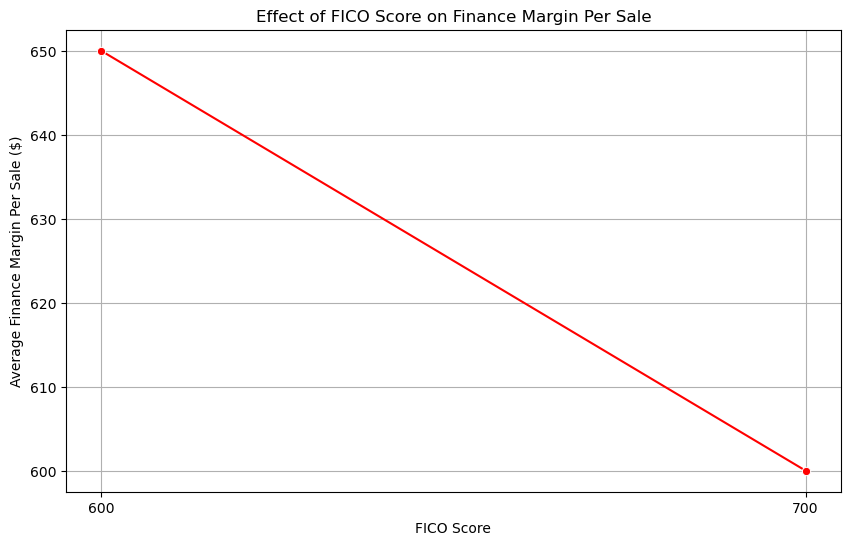

In [ ]:
# Average finance margin per sale
fico_finance_margin = df_control.groupby('fico')['finance margin'].mean().reset_index()
print(fico_finance_margin)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='fico', y='finance margin', data=fico_finance_margin, marker='o', color='r')

plt.title('Effect of FICO Score on Finance Margin Per Sale')
plt.xlabel('FICO Score')
plt.ylabel('Average Finance Margin Per Sale ($)')
plt.grid(True)
plt.xticks(fico_finance_margin['fico'].unique())

plt.show()



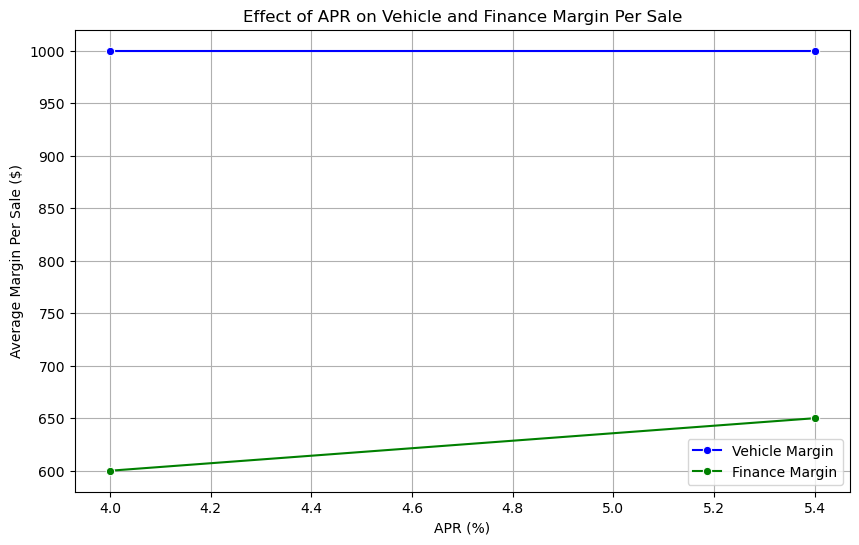

In [ ]:
# Grouping by APR and calculating both vehicle margin and finance margin
apr_margin = df_control.groupby('apr').agg({
    'vehicle margin': 'mean',
    'finance margin': 'mean'
}).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='apr', y='vehicle margin', data=apr_margin, marker='o', label='Vehicle Margin', color='b')
sns.lineplot(x='apr', y='finance margin', data=apr_margin, marker='o', label='Finance Margin', color='g')

plt.title('Effect of APR on Vehicle and Finance Margin Per Sale')
plt.xlabel('APR (%)')
plt.ylabel('Average Margin Per Sale ($)')
plt.grid(True)
plt.legend()
plt.show()


[Go to top of the page](#outline)<br>

### Recommendations <a class="anchor" id = "q4"></a>
#### Conversion Rate Comparison by FICO Score for each APR test group <br>


Conversion Rate Comparison by FICO Score (Control vs Test Group):
   fico  conversion_rate_control  conversion_rate_test  absolute_difference
0   600                20.490677             23.889115             3.398438
1   700                26.390581             29.666864             3.276283


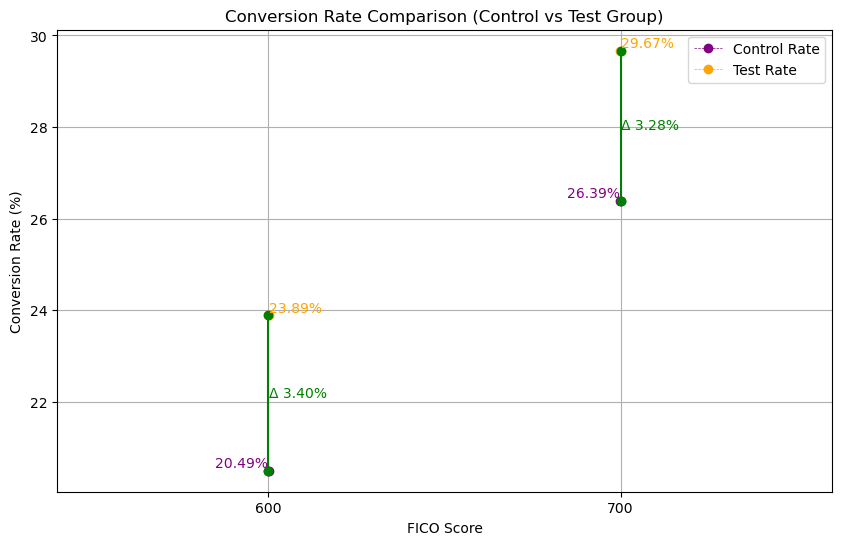

In [ ]:
# Part 1: Conversion Rate Comparison by FICO Score for each APR test group

# Total applications and conversions by FICO score for control group
fico_conversion_summary_control = df_control.groupby('fico')['converted to sale'].agg(['sum', 'count']).reset_index()
fico_conversion_summary_control.columns = ['fico', 'total_conversions', 'total_applications']
fico_conversion_summary_control['conversion_rate'] = fico_conversion_summary_control['total_conversions'] / fico_conversion_summary_control['total_applications'] * 100

# Total applications and conversions by FICO score for test group
fico_conversion_summary_test = df_test_group.groupby('fico')['converted to sale'].agg(['sum', 'count']).reset_index()
fico_conversion_summary_test.columns = ['fico', 'total_conversions', 'total_applications']
fico_conversion_summary_test['conversion_rate'] = fico_conversion_summary_test['total_conversions'] / fico_conversion_summary_test['total_applications'] * 100

fico_combined = pd.concat([fico_conversion_summary_control, fico_conversion_summary_test])
fico_comparison_summary = pd.merge(fico_conversion_summary_control, fico_conversion_summary_test, on='fico', suffixes=('_control', '_test'))

# Difference in conversion rates for each APR test group
fico_comparison_summary['absolute_difference'] = fico_comparison_summary['conversion_rate_test'] - fico_comparison_summary['conversion_rate_control']
print("\nConversion Rate Comparison by FICO Score (Control vs Test Group):")
print(fico_comparison_summary[['fico', 'conversion_rate_control', 'conversion_rate_test', 'absolute_difference']])

# Plot
plt.figure(figsize=(10, 6))
color_control = 'purple'
color_test = 'orange'

for index, row in fico_comparison_summary.iterrows():
    fico_score = row['fico']
    conversion_rate_control = row['conversion_rate_control']
    conversion_rate_test = row['conversion_rate_test']
    abs_diff = row['absolute_difference']

    plt.plot([fico_score - 0.2, fico_score + 0.2], [conversion_rate_control, conversion_rate_control], marker='o', linestyle='--', linewidth=0.5, color=color_control, label='Control Rate' if index == 0 else "")
    plt.plot([fico_score - 0.2, fico_score + 0.2], [conversion_rate_test, conversion_rate_test], marker='o', linestyle='--', linewidth=0.5, color=color_test, label='Test Rate' if index == 0 else "")
    plt.plot([fico_score, fico_score], [conversion_rate_control, conversion_rate_test], color='green', marker='o', linewidth=1.5)

    # Annotate the points
    plt.text(fico_score - 0.2, conversion_rate_control, f'{conversion_rate_control:.2f}%', verticalalignment='bottom', horizontalalignment='right', color=color_control)
    plt.text(fico_score + 0.2, conversion_rate_test, f'{conversion_rate_test:.2f}%', verticalalignment='bottom', horizontalalignment='left', color=color_test)
    plt.text(fico_score + 0.2, (conversion_rate_test + conversion_rate_control) / 2, f'Δ {abs_diff:.2f}%', horizontalalignment='left', verticalalignment='center', color='green')

plt.title('Conversion Rate Comparison (Control vs Test Group)')
plt.xlabel('FICO Score')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)
plt.xticks(fico_comparison_summary['fico'])
plt.xlim(min(fico_comparison_summary['fico']) - 60, max(fico_comparison_summary['fico']) + 60)
plt.legend()

plt.show()


Total Margin Comparison by FICO Score (Control vs Test Group):
   fico  total_margin_control  total_margin_test  total_margin_difference($)
0   600             1722600.0          1640800.0                    -81800.0
1   700             2080000.0          2031750.0                    -48250.0


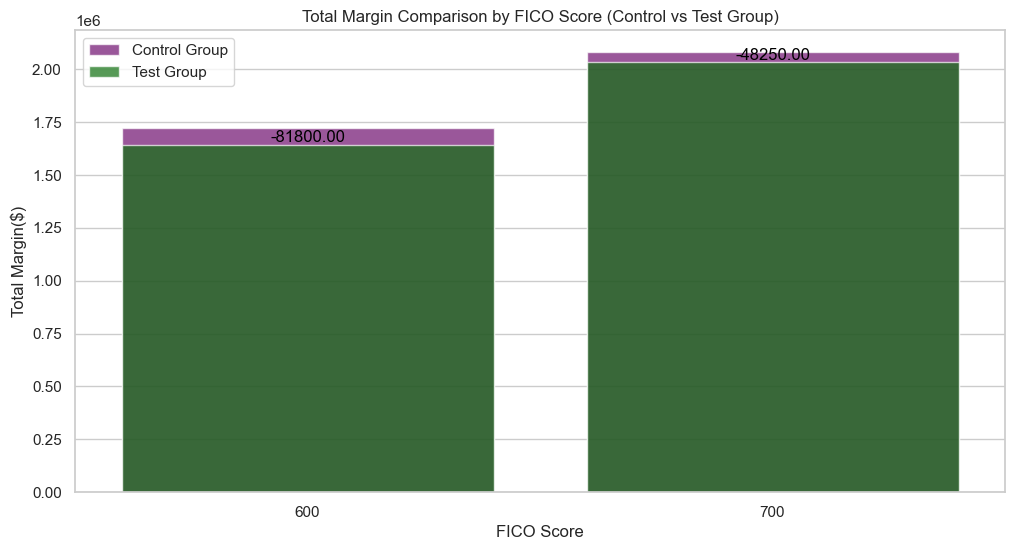

In [ ]:
# Part 2: Total Margin Comparison by FICO Score for each APR test group

# Total applications and conversions by FICO score for both control and test groups
fico_conversion_summary_control = df_control.groupby(['fico', 'apr'])['converted to sale'].agg(['sum', 'count']).reset_index()
fico_conversion_summary_control.columns = ['fico', 'apr', 'total_conversions_control', 'total_applications_control']
fico_conversion_summary_control['conversion_rate_control'] = fico_conversion_summary_control['total_conversions_control'] / fico_conversion_summary_control['total_applications_control'] * 100

fico_conversion_summary_test = df_test_group.groupby(['fico', 'apr'])['converted to sale'].agg(['sum', 'count']).reset_index()
fico_conversion_summary_test.columns = ['fico', 'apr', 'total_conversions_test', 'total_applications_test']
fico_conversion_summary_test['conversion_rate_test'] = fico_conversion_summary_test['total_conversions_test'] / fico_conversion_summary_test['total_applications_test'] * 100

total_margin_control = df_control.groupby(['fico', 'apr'])['total margin'].sum().reset_index()
total_margin_control.columns = ['fico', 'apr', 'total_margin_control']
total_margin_test = df_test_group.groupby(['fico', 'apr'])['total margin'].sum().reset_index()
total_margin_test.columns = ['fico', 'apr', 'total_margin_test']

# Merge
total_margin_summary = pd.merge(fico_conversion_summary_control, total_margin_control, on=['fico'])
total_margin_summary = pd.merge(total_margin_summary, total_margin_test, on=['fico'])

# Difference in total margin
total_margin_summary['total_margin_difference($)'] = total_margin_summary['total_margin_test'] - total_margin_summary['total_margin_control']
print("Total Margin Comparison by FICO Score (Control vs Test Group):")
print(total_margin_summary[['fico','total_margin_control','total_margin_test','total_margin_difference($)']])

#Plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(x='fico', y='total_margin_control', data=total_margin_summary, color='purple', label='Control Group', alpha=0.7)
sns.barplot(x='fico', y='total_margin_test', data=total_margin_summary, color='green', label='Test Group', alpha=0.7)

for i in range(len(total_margin_summary)):
    plt.text(x=i, y=total_margin_summary['total_margin_test'].iloc[i] + 5,
             s=f"{total_margin_summary['total_margin_difference($)'].iloc[i]:.2f}",
             ha='center', va='bottom', color='black')

plt.xlabel('FICO Score')
plt.ylabel('Total Margin($)')
plt.title('Total Margin Comparison by FICO Score (Control vs Test Group)')
plt.legend()
plt.show()


Profitability Comparison by FICO Score (Control vs Test Group):
   fico  profitability_control  profitability_test  \
0   600             338.096173          334.447615   
1   700             422.249289          400.502661   

   profitability_difference($)  
0                    -3.648558  
1                   -21.746628  


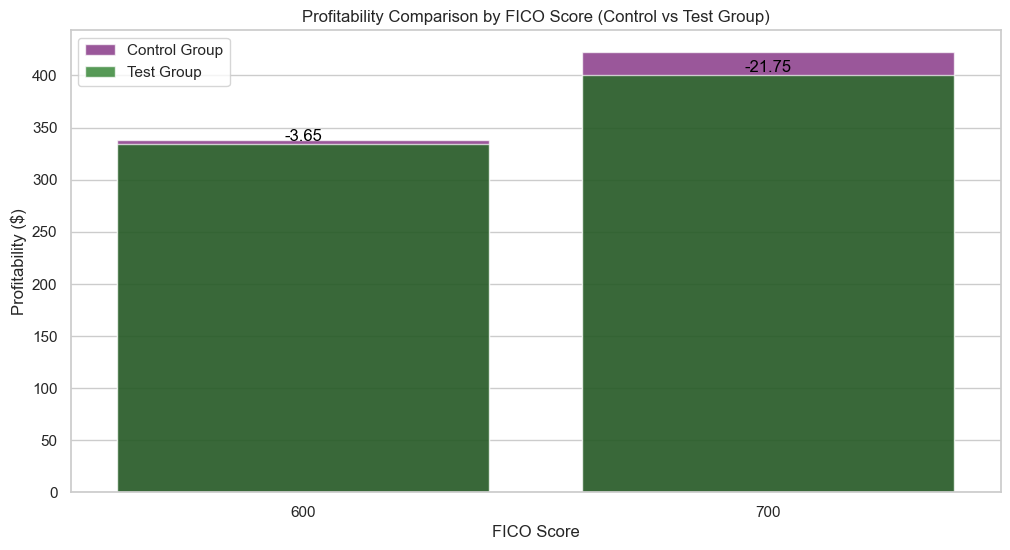

In [ ]:
# Additionally, I have also checked for profitability per application and per sale for testing the new APR Values

# Profitability per application vs FICO score
data = {
    'fico':  sorted(set(fico_conversion_summary['fico']) & set(fico_conversion_summary_test['fico'])),
    'conversion_rate_control': fico_conversion_summary['conversion_rate'],
    'conversion_rate_test': fico_conversion_summary_test['conversion_rate_test'],
    'total_applications_control': fico_conversion_summary['total_applications'],  # Aggregate total applications
    'total_applications_test': fico_conversion_summary_test['total_applications_test'],  # Aggregate total applications
    'total_margin_control': total_margin_control['total_margin_control'],
    'total_margin_test': total_margin_test['total_margin_test']
}

df_comparison = pd.DataFrame(data)

df_comparison['profitability_control'] = df_comparison['total_margin_control'] / df_comparison['total_applications_control']
df_comparison['profitability_test'] = df_comparison['total_margin_test'] / df_comparison['total_applications_test']
df_comparison['profitability_difference($)'] = df_comparison['profitability_test'] - df_comparison['profitability_control']

print("Profitability Comparison by FICO Score (Control vs Test Group):")
print(df_comparison[['fico', 'profitability_control', 'profitability_test', 'profitability_difference($)']])

# Plot
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='fico', y='profitability_control', data=df_comparison, color='purple', label='Control Group', alpha=0.7, ax=ax)
sns.barplot(x='fico', y='profitability_test', data=df_comparison, color='green', label='Test Group', alpha=0.7, ax=ax)

for i in range(len(df_comparison)):
    ax.text(x=i, y=df_comparison['profitability_test'].iloc[i] + 0.05,
            s=f"{df_comparison['profitability_difference($)'].iloc[i]:.2f}",
            ha='center', va='bottom', color='black')

ax.set_xlabel('FICO Score')
ax.set_ylabel('Profitability ($)')
ax.set_title('Profitability Comparison by FICO Score (Control vs Test Group)')
ax.legend()

plt.show()


Sale Margin Comparison by FICO Score (Control vs Test Group):
   fico  sale_margin_control  sale_margin_test  sale_margin_difference
0   600               1650.0            1400.0                  -250.0
1   700               1600.0            1350.0                  -250.0


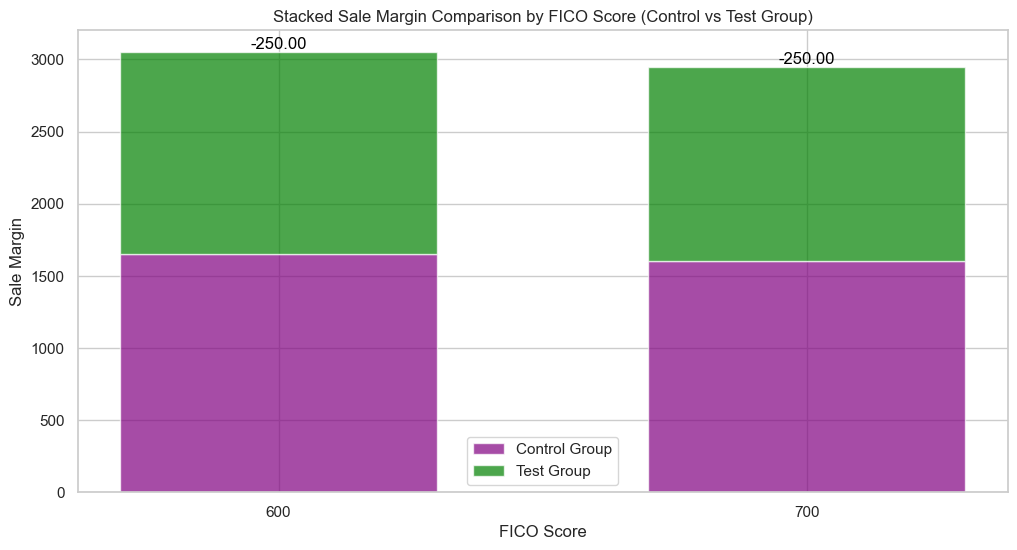

In [ ]:
# # Profitability per application vs FICO score
df_comparison['total_sales_control'] = df_comparison['total_applications_control'] * (df_comparison['conversion_rate_control'] / 100)
df_comparison['total_sales_test'] = df_comparison['total_applications_test'] * (df_comparison['conversion_rate_test'] / 100)


df_comparison['sale_margin_control'] = df_comparison['total_margin_control'] / df_comparison['total_sales_control']
df_comparison['sale_margin_test'] = df_comparison['total_margin_test'] / df_comparison['total_sales_test']
df_comparison['sale_margin_difference'] = df_comparison['sale_margin_test'] - df_comparison['sale_margin_control']

print("Sale Margin Comparison by FICO Score (Control vs Test Group):")
print(df_comparison[['fico', 'sale_margin_control', 'sale_margin_test', 'sale_margin_difference']])


# Plot
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_comparison))
bar_width = 0.6

bars_control = ax.bar(x, df_comparison['sale_margin_control'], bar_width, color='purple', label='Control Group', alpha=0.7)
bars_test = ax.bar(x, df_comparison['sale_margin_test'], bar_width, bottom=df_comparison['sale_margin_control'], color='green', label='Test Group', alpha=0.7)

for i in range(len(df_comparison)):
    total_height = df_comparison['sale_margin_control'].iloc[i] + df_comparison['sale_margin_test'].iloc[i]
    ax.text(x[i], total_height + 0.05,
            s=f"{df_comparison['sale_margin_difference'].iloc[i]:.2f}",
            ha='center', va='bottom', color='black')

ax.set_xlabel('FICO Score')
ax.set_ylabel('Sale Margin')
ax.set_title('Stacked Sale Margin Comparison by FICO Score (Control vs Test Group)')
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['fico'])
ax.legend()

plt.show()


[Go to top of the page](#outline)<br>

### Other Factors to Consider<a class="anchor" id = "q5"></a>
Some factors to consider for recommendation are:<br>
* Lower APRs may increase the volume of financed sales but this impacts the cost structure for the company as a whole; hence, there is a need to assess what CarPro will take on in terms of financing costs.<br>
* Runs the risk of higher delinquencies or defaults with lower APRs. Perform historical data analysis for the tendency of lower APRs reflecting into higher default rates.<br>
* Ensuring that this short-term win in conversion rates is not translated into unsustainable losses over time.<br>
* Consider how APR changes might affect CarPro's brand perception. Offering lower APRs might attract more customers but could also impact the perceived value of your services. *
* Brand positioning among competitors is also dependent on this so maintain a good APR pricing in comparison to competitors and still maintain profitability.<br>
* Identify the sensitivity of different customer segments to APR changes. Identify the APR level, which can help maximize the conversions without significantly impacting margins.<br>

[Go to top of the page](#outline)<br>

### Conclusion and Notes <a class="anchor" id = "notes"></a>
<h4> In conclusion, lowering APRs boost conversion rates, especially for lower-FICO customers, but it reduces finance margins.
And, higher APRs maintain profitability for higher-FICO customers with minimal impact on conversion rates.</h4>

Recommendations:

* Target lower APRs for lower-FICO customers to increase conversions while managing margin impact.<br>
* Maintain higher APRs for higher-FICO customers to maximize finance margins.<br>

Author Note:
------------------
I have provided data-driven recommendation and conclusion based on my analysis. Various other factors play a big role in identifying the ideal APR to offer the customers and some of them are listed above<br>

More extensive analysis could help in identifying causes for various patterns uncovered in this script and this could potentially help us understand lowering APR for specific segments can increase profitability<br>
Some of the scenarios to consider are:<br>
* Tenure of financing<br>
* Considering credit length and history along with FICO score.<br>
* Analyze vehicle that offer good profit and offer lower APR based on vehicle types.<br>
* Offer lower APR on vehicles that are on inventory for long time.<br><br>

I have explored the analysis using various regression models and was unfruitful due to the discreteness of the data which caused the models to overfit. With a balanced dataset, exploring regression models is also worthwhile investment for the analysis. <br>

[Go to top of the page](#outline)<br>

### Additional EDA that I performed for Reference<a class="anchor" id = "eda"></a>


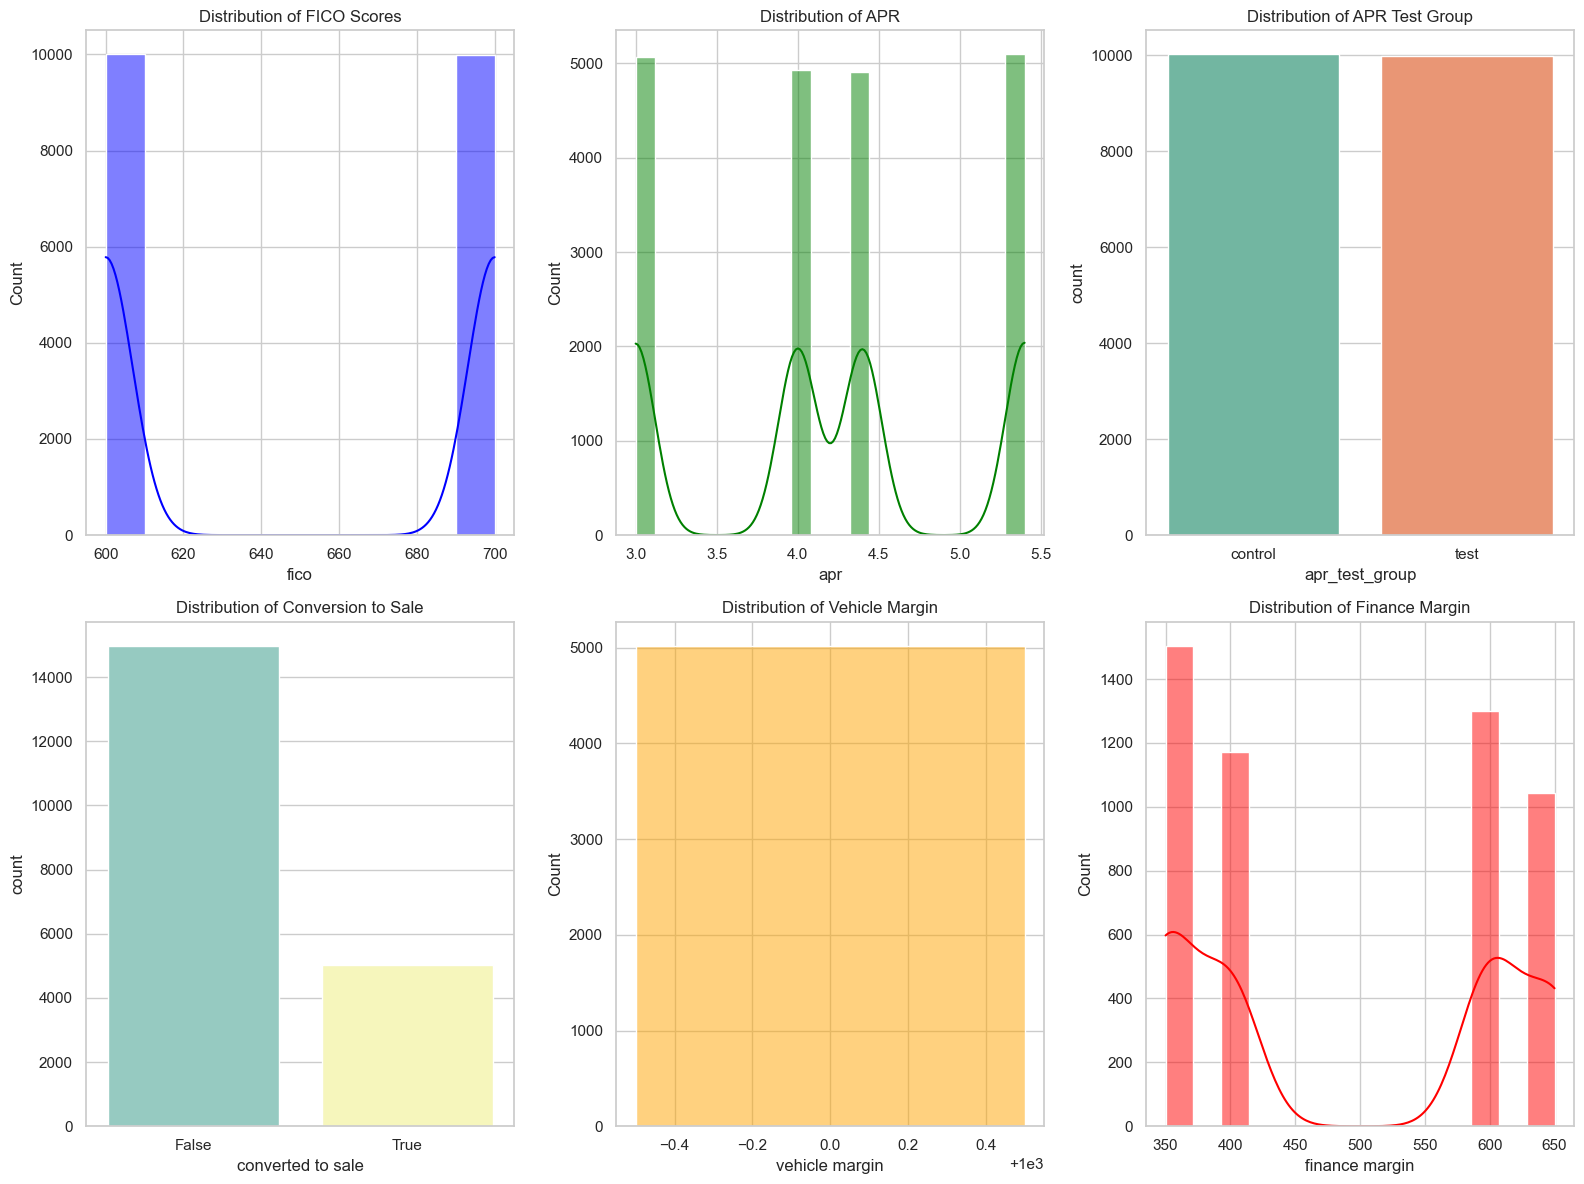

In [ ]:
# Univariate Analysis: Distribution of each column
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
sns.histplot(df['fico'], kde=True, bins=10, color='blue')
plt.title('Distribution of FICO Scores')

plt.subplot(2, 3, 2)
sns.histplot(df['apr'], kde=True, bins=20, color='green')
plt.title('Distribution of APR')

plt.subplot(2, 3, 3)
sns.countplot(x='apr_test_group', data=df, palette='Set2')
plt.title('Distribution of APR Test Group')

plt.subplot(2, 3, 4)
sns.countplot(x='converted to sale', data=df, palette='Set3')
plt.title('Distribution of Conversion to Sale')

plt.subplot(2, 3, 5)
sns.histplot(df['vehicle margin'], kde=True, color='orange')
plt.title('Distribution of Vehicle Margin')

plt.subplot(2, 3, 6)
sns.histplot(df['finance margin'], kde=True, color='red')
plt.title('Distribution of Finance Margin')

plt.tight_layout()
plt.show()

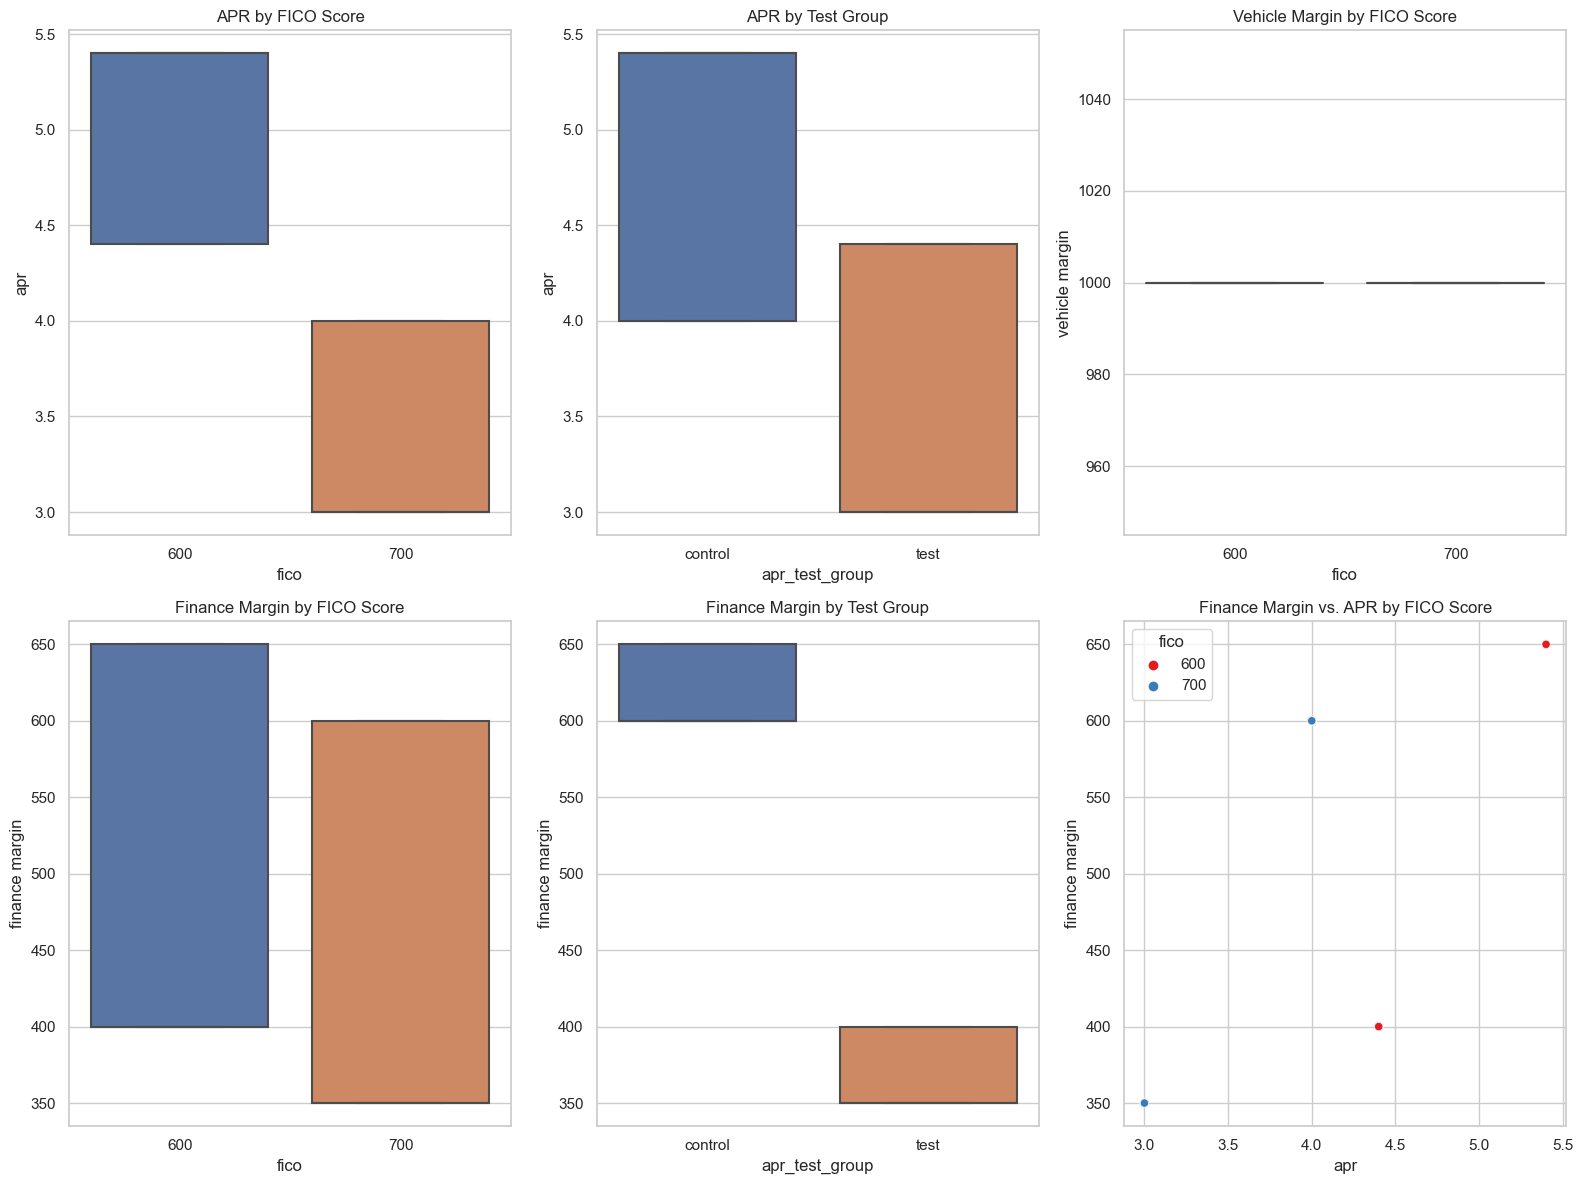

In [ ]:
# Bivariate Analysis: Exploring relationships
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
sns.boxplot(x='fico', y='apr', data=df)
plt.title('APR by FICO Score')

plt.subplot(2, 3, 2)
sns.boxplot(x='apr_test_group', y='apr', data=df)
plt.title('APR by Test Group')

plt.subplot(2, 3, 3)
sns.boxplot(x='fico', y='vehicle margin', data=df)
plt.title('Vehicle Margin by FICO Score')

plt.subplot(2, 3, 4)
sns.boxplot(x='fico', y='finance margin', data=df)
plt.title('Finance Margin by FICO Score')

plt.subplot(2, 3, 5)
sns.boxplot(x='apr_test_group', y='finance margin', data=df)
plt.title('Finance Margin by Test Group')

plt.subplot(2, 3, 6)
sns.scatterplot(x='apr', y='finance margin', hue='fico', data=df, palette='Set1')
plt.title('Finance Margin vs. APR by FICO Score')

plt.tight_layout()
plt.show()

                    fico       apr  vehicle margin  finance margin
fico            1.000000 -0.817032        0.067975        0.036052
apr            -0.817032  1.000000       -0.077723        0.030543
vehicle margin  0.067975 -0.077723        1.000000        0.957540
finance margin  0.036052  0.030543        0.957540        1.000000


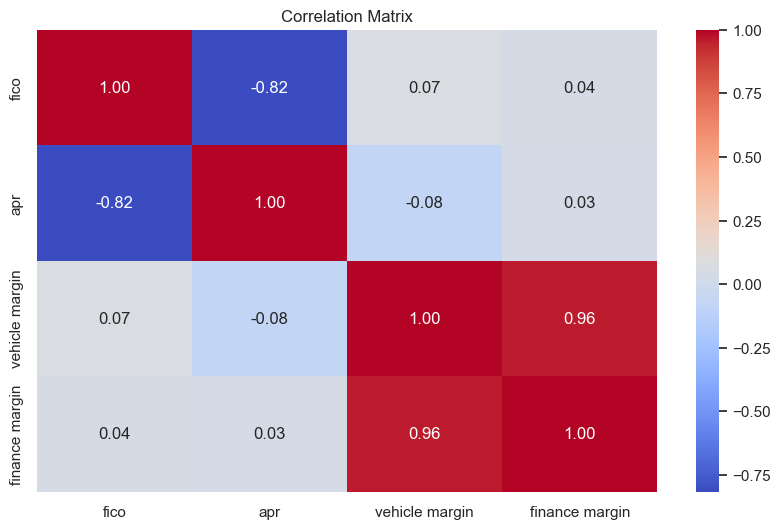

In [ ]:
#Correlation Matrix
# Replace NaN values with 0 for margin for ease of calculation
columns_with_nan = ['vehicle margin', 'finance margin']
df[columns_with_nan] = df[columns_with_nan].fillna(0)

# Correlation Matrix
corr_matrix = df[['fico', 'apr', 'vehicle margin', 'finance margin']].corr()
print (corr_matrix)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Total Margin Analysis by FICO and APR Test Group
   fico apr_test_group  vehicle margin  finance margin  total margin
0   600        control      204.906771      133.189401    338.096173
1   600           test      238.891154       95.556461    334.447615
2   700        control      263.905806      158.343484    422.249289
3   700           test      296.668638      103.834023    400.502661


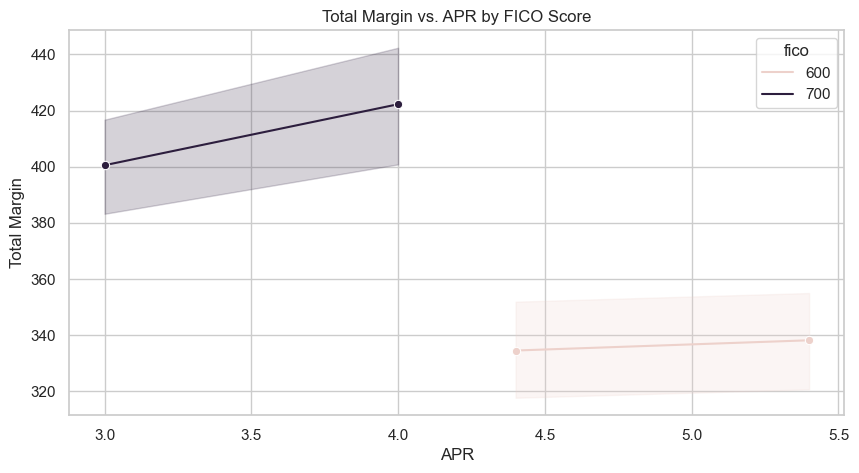

In [ ]:
# Analysis of total margin (vehicle + finance)
df['total margin'] = df['vehicle margin'] + df['finance margin']

total_margin_analysis = df.groupby(['fico', 'apr_test_group'])[['vehicle margin', 'finance margin','total margin']].mean().reset_index()
print("\nTotal Margin Analysis by FICO and APR Test Group")
print(total_margin_analysis)

plt.figure(figsize=(10, 5))
sns.lineplot(x='apr', y='total margin', hue='fico', data=df, marker='o')
plt.title('Total Margin vs. APR by FICO Score')
plt.xlabel('APR')
plt.ylabel('Total Margin')
plt.show()



### End of file